In [32]:
pip install XGBoost

Note: you may need to restart the kernel to use updated packages.


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


df = pd.read_csv("Supermart Grocery Sales - Retail Analytics Dataset.csv")

In [34]:
df.head(10)

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu
5,OD6,Adavan,Food Grains,Organic Staples,Dharmapuri,06-09-2015,West,2305,0.26,322.70,Tamil Nadu
6,OD7,Jonas,Fruits & Veggies,Fresh Vegetables,Trichy,06-09-2015,West,826,0.33,346.92,Tamil Nadu
7,OD8,Hafiz,Fruits & Veggies,Fresh Fruits,Ramanadhapuram,06-09-2015,West,1847,0.32,147.76,Tamil Nadu
8,OD9,Hafiz,Bakery,Biscuits,Tirunelveli,06-09-2015,West,791,0.23,181.93,Tamil Nadu
9,OD10,Krithika,Bakery,Cakes,Chennai,06-09-2015,West,1795,0.27,484.65,Tamil Nadu


In [35]:
df.describe()

,Sales,Discount,Profit
count,9994.000000,9994.000000,9994.000000
mean,1496.596158,0.226817,374.937082
std,577.559036,0.074636,239.932881
min,500.000000,0.100000,25.250000
25%,1000.000000,0.160000,180.022500
50%,1498.000000,0.230000,320.780000
75%,1994.750000,0.290000,525.627500
max,2500.000000,0.350000,1120.950000


In [36]:
df.isna().sum()

Order ID         0
Customer Name    0
Category         0
Sub Category     0
City             0
Order Date       0
Region           0
Sales            0
Discount         0
Profit           0
State            0
dtype: int64

In [37]:
df_cleaned = df.drop(['Order ID','Customer Name','State'],axis=1)
df_cleaned.dtypes

Category         object
Sub Category     object
City             object
Order Date       object
Region           object
Sales             int64
Discount        float64
Profit          float64
dtype: object

In [38]:
for col in df_cleaned:
    print(df_cleaned[col].unique())

['Oil & Masala' 'Beverages' 'Food Grains' 'Fruits & Veggies' 'Bakery'
 'Snacks' 'Eggs, Meat & Fish']
['Masalas' 'Health Drinks' 'Atta & Flour' 'Fresh Vegetables'
 'Organic Staples' 'Fresh Fruits' 'Biscuits' 'Cakes' 'Chocolates' 'Eggs'
 'Cookies' 'Chicken' 'Edible Oil & Ghee' 'Mutton' 'Soft Drinks'
 'Dals & Pulses' 'Organic Vegetables' 'Noodles' 'Organic Fruits' 'Fish'
 'Spices' 'Rice' 'Breads & Buns']
['Vellore' 'Krishnagiri' 'Perambalur' 'Dharmapuri' 'Ooty' 'Trichy'
 'Ramanadhapuram' 'Tirunelveli' 'Chennai' 'Karur' 'Namakkal' 'Dindigul'
 'Kanyakumari' 'Bodi' 'Tenkasi' 'Viluppuram' 'Madurai' 'Salem' 'Cumbum'
 'Nagercoil' 'Pudukottai' 'Theni' 'Coimbatore' 'Virudhunagar']
['11-08-2017' '06-12-2017' '10-11-2016' ... '3/16/2015' '8/29/2016'
 '04-06-2017']
['North' 'South' 'West' 'Central' 'East']
[1254  749 2360 ... 1679 1582 1162]
[0.12 0.18 0.21 0.25 0.26 0.33 0.32 0.23 0.27 0.13 0.1  0.19 0.22 0.11
 0.28 0.35 0.29 0.34 0.17 0.24 0.16 0.2  0.31 0.3  0.15 0.14]
[401.28 149.8  165.2  ... 4

### Masalas Sales Prediction

In [39]:
df_cleaned
df2_masala = df_cleaned.loc[df_cleaned['Sub Category'] == 'Masalas']
df2 = df2_masala[['Sales','Order Date']]
df2['Order Date'] = df2['Order Date'].str.replace('/','-')
df2_grouped = df2.groupby(['Order Date']).sum()
df2_grouped

,Sales
Order Date,
01-01-2018,1353
01-02-2017,1152
01-02-2018,1846
01-03-2016,2419
01-06-2015,3372
...,...
9-24-2018,2281
9-25-2016,1588
9-25-2017,1137


In [40]:
df2_grouped.index = pd.to_datetime(df2_grouped.index,format="%m-%d-%Y", errors='coerce', dayfirst=True)

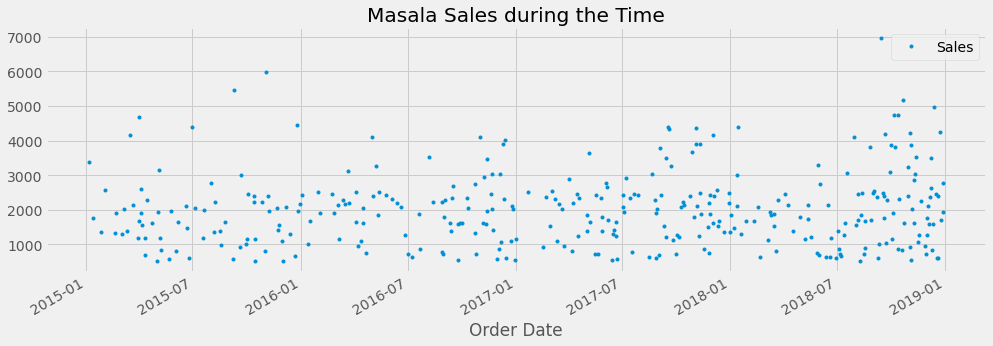

In [41]:
df2_grouped.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Masala Sales during the Time')
plt.show()


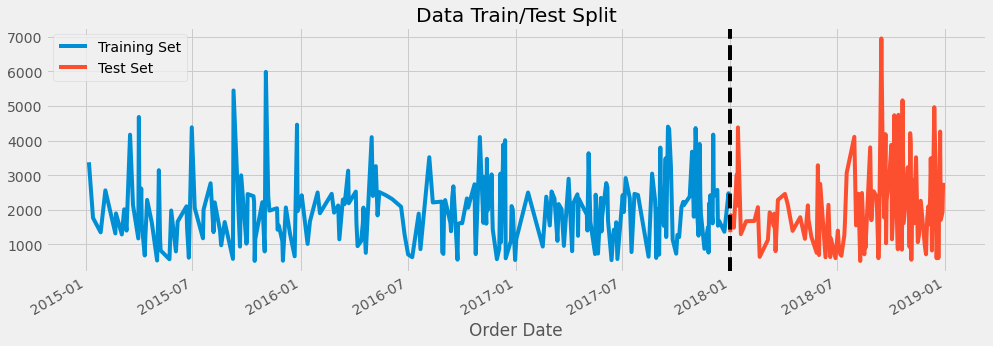

In [42]:
train = df2_grouped.loc[df2_grouped.index < '01-01-2018']
test = df2_grouped.loc[df2_grouped.index >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [43]:
# df2_grouped.loc[(df2_grouped.index > '01-01-2016') & (df2_grouped.index < '01-08-2016')] \
#     .plot(figsize=(15, 5), title='Week Of Data')
# plt.show()

In [44]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df2_grouped = create_features(df2_grouped)

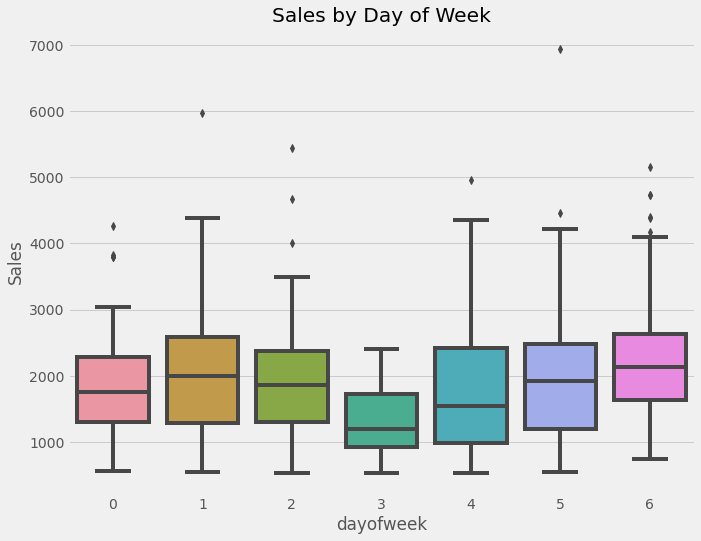

In [45]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2_grouped, x='dayofweek', y='Sales')
ax.set_title('Sales by Day of Week')
plt.show()

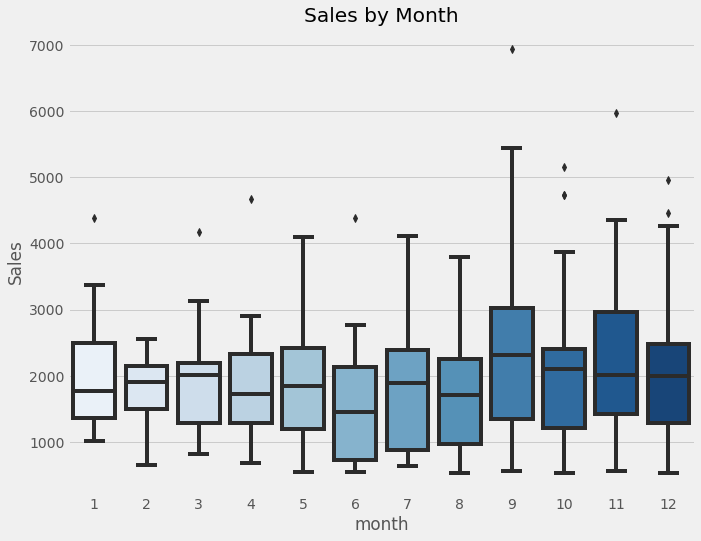

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2_grouped, x='month', y='Sales', palette='Blues')
ax.set_title('Sales by Month')
plt.show()

In [47]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Sales'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [48]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[11:55:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2183.34771	validation_1-rmse:2370.77948
[100]	validation_0-rmse:1169.14997	validation_1-rmse:1434.27587
[200]	validation_0-rmse:902.77518	validation_1-rmse:1235.86567
[300]	validation_0-rmse:829.40508	validation_1-rmse:1203.89480
[400]	validation_0-rmse:796.89599	validation_1-rmse:1200.25894
[472]	validation_0-rmse:778.06939	validation_1-rmse:1201.59378


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

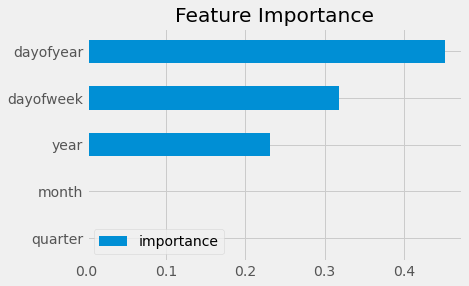

In [49]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

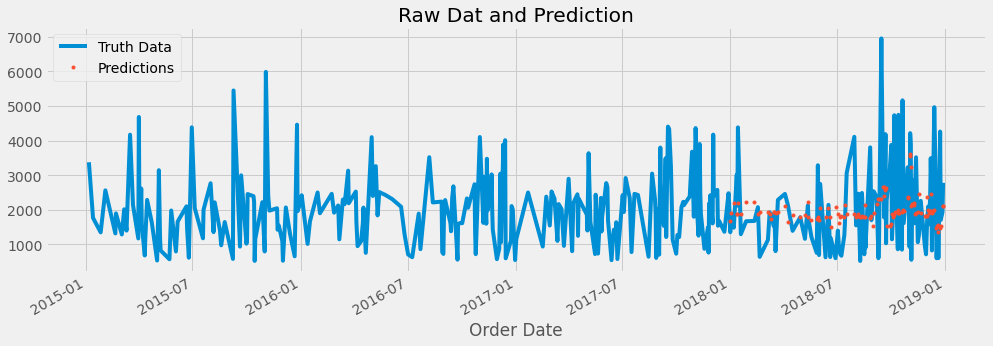

In [50]:
test['prediction'] = reg.predict(X_test)
df = df2_grouped.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df2_grouped[['Sales']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [51]:
score = np.sqrt(mean_squared_error(test['Sales'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1199.71


In [52]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2018-09-15    4638.485107
2018-10-21    3160.176636
2018-12-14    2956.878174
2018-10-07    2865.412842
2018-12-24    2774.978149
2018-10-14    2754.921387
2018-11-02    2675.010742
2018-10-02    2285.799561
2018-07-31    2238.578369
2018-01-14    2174.403320
Name: error, dtype: float64

### Prophet Model

In [53]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


df = pd.read_csv("Supermart Grocery Sales - Retail Analytics Dataset.csv")

In [5]:
df_cleaned = df.drop(['Order ID','Customer Name','State'],axis=1)
df_cleaned.dtypes

Category         object
Sub Category     object
City             object
Order Date       object
Region           object
Sales             int64
Discount        float64
Profit          float64
dtype: object

In [6]:
df_cleaned
df2_masala = df_cleaned.loc[df_cleaned['Sub Category'] == 'Masalas']
df2 = df2_masala[['Sales','Order Date']]
df2['Order Date'] = df2['Order Date'].str.replace('/','-')
df2_grouped = df2.groupby(['Order Date']).sum()
df2_grouped
df2_grouped.index = pd.to_datetime(df2_grouped.index,format="%m-%d-%Y", errors='coerce', dayfirst=True)

In [7]:
df2_grouped

,Sales
Order Date,
2018-01-01,1353
2017-01-02,1152
2018-01-02,1846
2016-01-03,2419
2015-01-06,3372
...,...
2018-09-24,2281
2016-09-25,1588
2017-09-25,1137


In [8]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df2_grouped, label='Sales')
features_and_target = pd.concat([X, y], axis=1)

In [9]:
features_and_target

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,Sales
Order Date,,,,,,,,,,
2018-01-01,0,1,1,2018,1,1,1,Monday,Winter,1353
2017-01-02,0,1,1,2017,2,2,1,Monday,Winter,1152
2018-01-02,1,1,1,2018,2,2,1,Tuesday,Winter,1846
2016-01-03,6,1,1,2016,3,3,53,Sunday,Winter,2419
2015-01-06,1,1,1,2015,6,6,2,Tuesday,Winter,3372
...,...,...,...,...,...,...,...,...,...,...
2018-09-24,0,3,9,2018,267,24,39,Monday,Fall,2281
2016-09-25,6,3,9,2016,269,25,38,Sunday,Fall,1588
2017-09-25,0,3,9,2017,268,25,39,Monday,Fall,1137


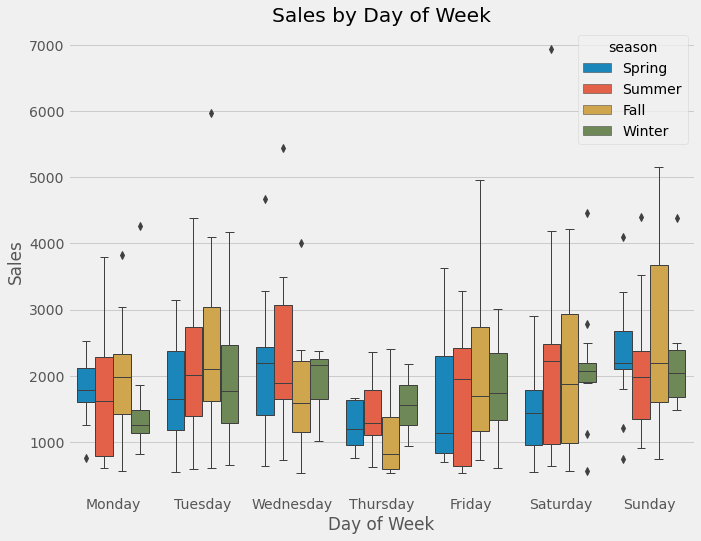

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(data=features_and_target,
            x='weekday',
            y='Sales',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Sales by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Sales')
# ax.legend(bbox_to_anchor=(1, 1))
plt.show()

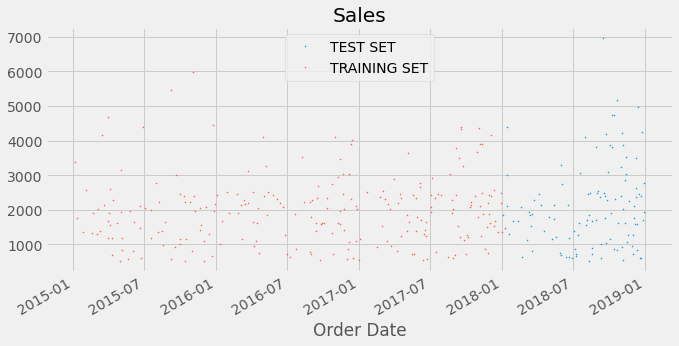

In [13]:
split_date = '1-Jan-2018'
masala_train = df2_grouped.loc[df2_grouped.index <= split_date].copy()
masala_test = df2_grouped.loc[df2_grouped.index > split_date].copy()

# Plot train and test so you can see where we have split
masala_test \
    .rename(columns={'Sales': 'TEST SET'}) \
    .join(masala_train.rename(columns={'Sales': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Sales', style='.', ms=1)
plt.show()

In [18]:
# Format data for prophet model using ds and y
masala_train_prophet = masala_train.reset_index() \
    .rename(columns={'Order Date':'ds',
                     'Sales':'y'})

In [19]:
%%time
model = Prophet()
model.fit(masala_train_prophet)

11:54:39 - cmdstanpy - INFO - Chain [1] start processing
11:54:39 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 1.09 s
Wall time: 1.8 s


In [20]:
masala_test_prophet = masala_test.reset_index() \
    .rename(columns={'Order Date':'ds',
                     'Sales':'y'})

masala_test_fcst = model.predict(masala_test_prophet)

In [21]:
masala_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,1883.673907,1040.401982,3285.640678,1883.673907,1883.673907,206.398582,206.398582,206.398582,269.183353,269.183353,269.183353,-62.784771,-62.784771,-62.784771,0.0,0.0,0.0,2090.072489
1,2018-01-07,1883.574167,760.810776,3162.564446,1883.574167,1883.574167,109.467037,109.467037,109.467037,330.863705,330.863705,330.863705,-221.396668,-221.396668,-221.396668,0.0,0.0,0.0,1993.041204
2,2018-01-12,1883.474427,598.563538,2934.185431,1883.474427,1883.474427,-155.836013,-155.836013,-155.836013,179.419416,179.419416,179.419416,-335.255429,-335.255429,-335.255429,0.0,0.0,0.0,1727.638414
3,2018-01-13,1883.454480,349.110836,2663.057749,1883.454458,1883.454539,-390.781582,-390.781582,-390.781582,-43.844090,-43.844090,-43.844090,-346.937493,-346.937493,-346.937493,0.0,0.0,0.0,1492.672897
4,2018-01-14,1883.434532,727.568568,2931.841355,1883.434434,1883.434641,-23.039957,-23.039957,-23.039957,330.863705,330.863705,330.863705,-353.903662,-353.903662,-353.903662,0.0,0.0,0.0,1860.394574


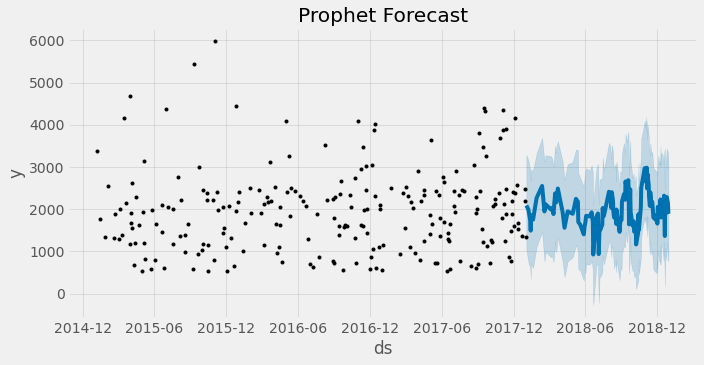

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(masala_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

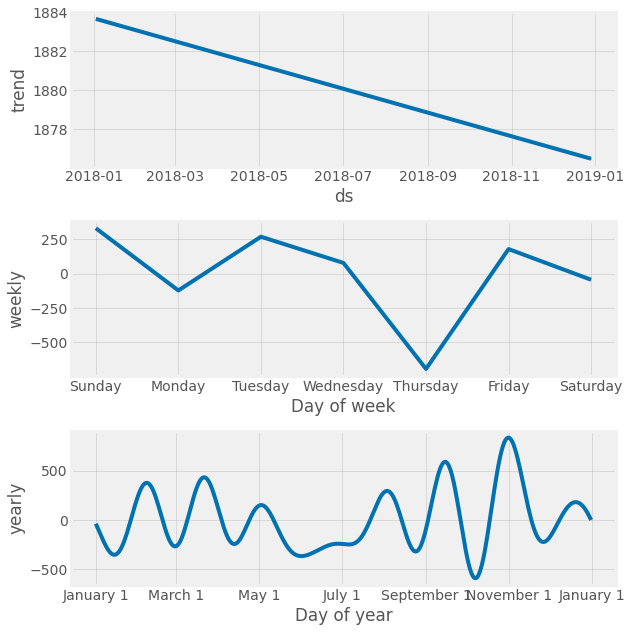

In [23]:
fig = model.plot_components(masala_test_fcst)
plt.show()

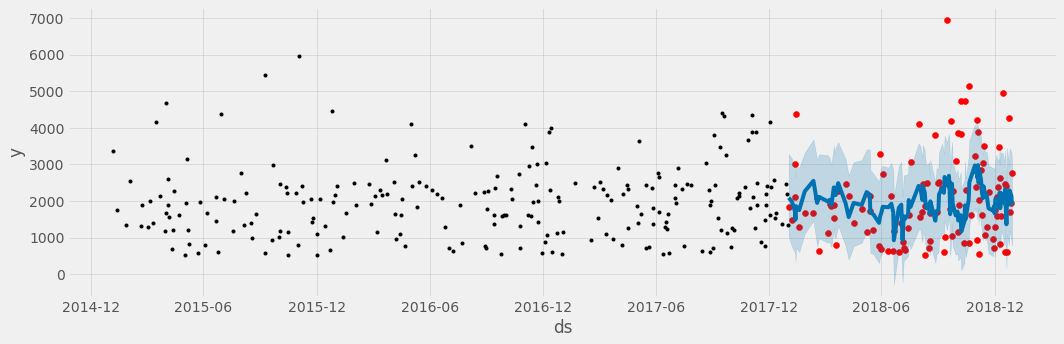

In [24]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(masala_test.index, masala_test['Sales'], color='r')
fig = model.plot(masala_test_fcst, ax=ax)

In [25]:
np.sqrt(mean_squared_error(y_true=masala_test['Sales'],
                   y_pred=masala_test_fcst['yhat']))

1325.8711428554038

In [26]:
mean_absolute_error(y_true=masala_test['Sales'],
                   y_pred=masala_test_fcst['yhat'])

1021.431977240438

In [27]:
mean_absolute_percentage_error(y_true=masala_test['Sales'],
                   y_pred=masala_test_fcst['yhat'])

67.76853170627358

# Mutton

In [28]:
df_cleaned
df2_Mutton = df_cleaned.loc[df_cleaned['Sub Category'] == 'Mutton']
df2 = df2_Mutton[['Sales','Order Date']]
df2['Order Date'] = df2['Order Date'].str.replace('/','-')
df2_grouped = df2.groupby(['Order Date']).sum()
df2_grouped

,Sales
Order Date,
01-02-2018,2066
01-03-2016,1371
01-05-2017,899
01-06-2018,1747
01-10-2017,1299
...,...
9-25-2018,4115
9-26-2016,2444
9-26-2018,993


In [29]:
df2_grouped.index = pd.to_datetime(df2_grouped.index,format="%m-%d-%Y", errors='coerce', dayfirst=True)

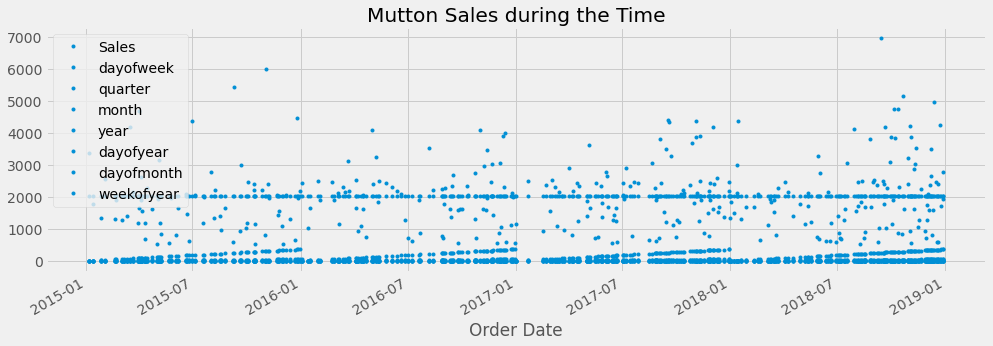

In [54]:
df2_grouped.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Mutton Sales during the Time')
plt.show()

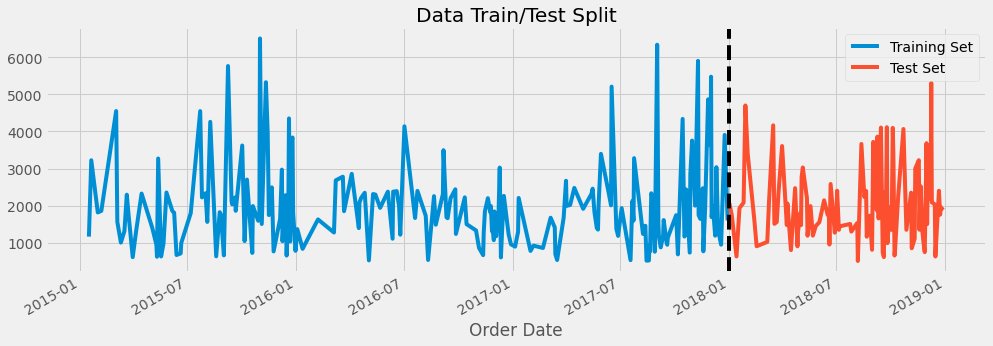

In [31]:
train = df2_grouped.loc[df2_grouped.index < '01-01-2018']
test = df2_grouped.loc[df2_grouped.index >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [55]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df2_grouped = create_features(df2_grouped)

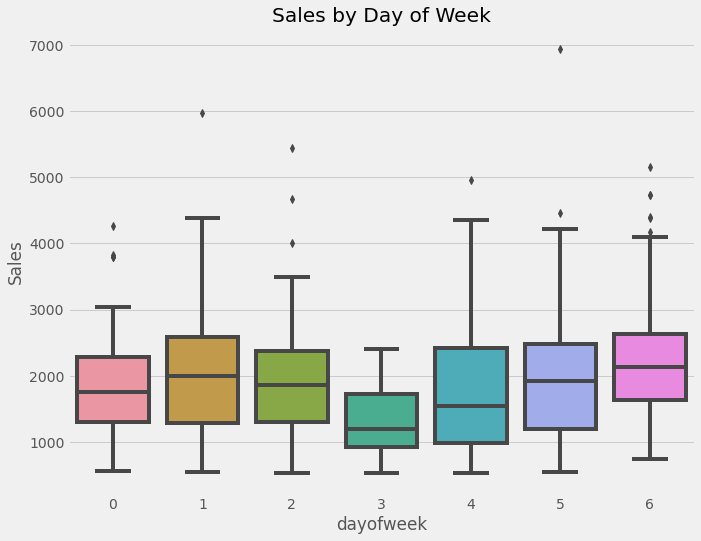

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2_grouped, x='dayofweek', y='Sales')
ax.set_title('Sales by Day of Week')
plt.show()

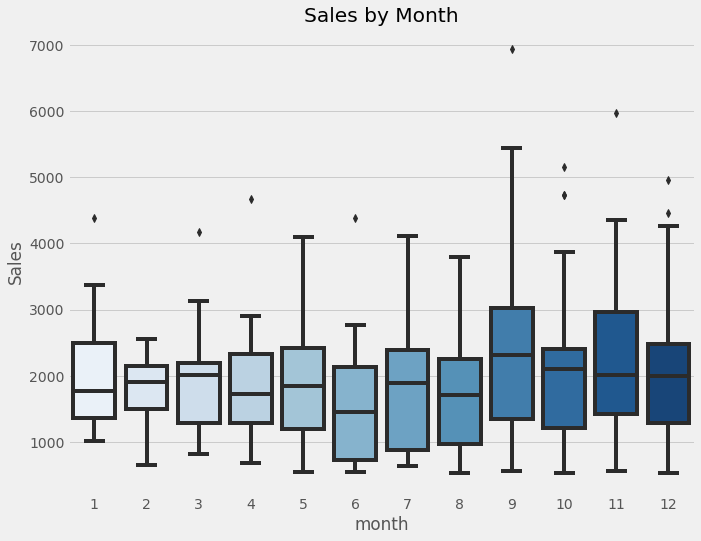

In [57]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2_grouped, x='month', y='Sales', palette='Blues')
ax.set_title('Sales by Month')
plt.show()

In [58]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Sales'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [59]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[11:55:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2183.34771	validation_1-rmse:2370.77948
[100]	validation_0-rmse:1169.14997	validation_1-rmse:1434.27587
[200]	validation_0-rmse:902.77518	validation_1-rmse:1235.86567
[300]	validation_0-rmse:829.40508	validation_1-rmse:1203.89480
[400]	validation_0-rmse:796.89599	validation_1-rmse:1200.25894
[472]	validation_0-rmse:778.06939	validation_1-rmse:1201.59378


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

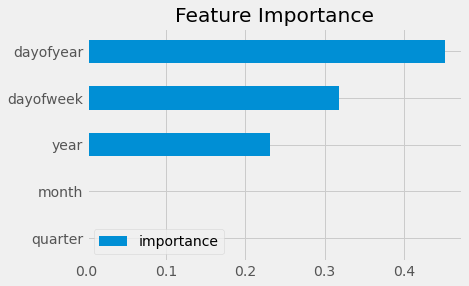

In [60]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

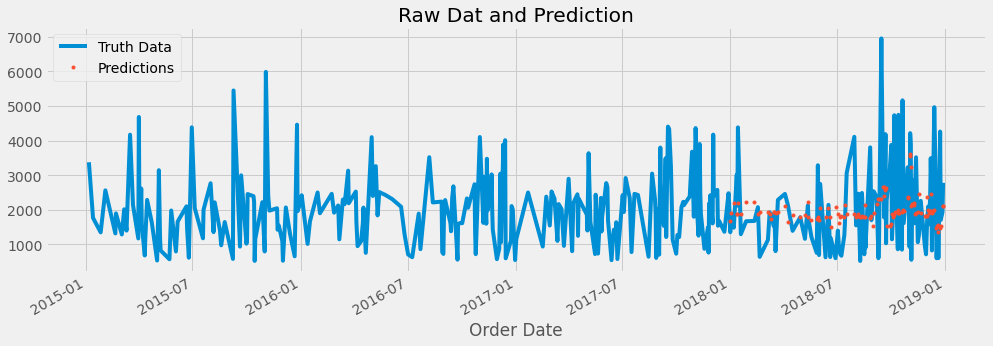

In [61]:
test['prediction'] = reg.predict(X_test)
df = df2_grouped.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df2_grouped[['Sales']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [62]:
score = np.sqrt(mean_squared_error(test['Sales'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1199.71


In [63]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2018-09-15    4638.485107
2018-10-21    3160.176636
2018-12-14    2956.878174
2018-10-07    2865.412842
2018-12-24    2774.978149
2018-10-14    2754.921387
2018-11-02    2675.010742
2018-10-02    2285.799561
2018-07-31    2238.578369
2018-01-14    2174.403320
Name: error, dtype: float64

## Prophet of Mutton

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


df = pd.read_csv("Supermart Grocery Sales - Retail Analytics Dataset.csv")

In [67]:
df_cleaned = df.drop(['Order ID','Customer Name','State'],axis=1)
df_cleaned.dtypes

Category         object
Sub Category     object
City             object
Order Date       object
Region           object
Sales             int64
Discount        float64
Profit          float64
dtype: object

In [68]:
df_cleaned
df2_Mutton = df_cleaned.loc[df_cleaned['Sub Category'] == 'Mutton']
df2 = df2_Mutton[['Sales','Order Date']]
df2['Order Date'] = df2['Order Date'].str.replace('/','-')
df2_grouped = df2.groupby(['Order Date']).sum()
df2_grouped
df2_grouped.index = pd.to_datetime(df2_grouped.index,format="%m-%d-%Y", errors='coerce', dayfirst=True)

In [69]:
df2_grouped

,Sales
Order Date,
2018-01-02,2066
2016-01-03,1371
2017-01-05,899
2018-01-06,1747
2017-01-10,1299
...,...
2018-09-25,4115
2016-09-26,2444
2018-09-26,993


In [70]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df2_grouped, label='Sales')
features_and_target = pd.concat([X, y], axis=1)

In [71]:
features_and_target

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,Sales
Order Date,,,,,,,,,,
2018-01-02,1,1,1,2018,2,2,1,Tuesday,Winter,2066
2016-01-03,6,1,1,2016,3,3,53,Sunday,Winter,1371
2017-01-05,3,1,1,2017,5,5,1,Thursday,Winter,899
2018-01-06,5,1,1,2018,6,6,1,Saturday,Winter,1747
2017-01-10,1,1,1,2017,10,10,2,Tuesday,Winter,1299
...,...,...,...,...,...,...,...,...,...,...
2018-09-25,1,3,9,2018,268,25,39,Tuesday,Fall,4115
2016-09-26,0,3,9,2016,270,26,39,Monday,Fall,2444
2018-09-26,2,3,9,2018,269,26,39,Wednesday,Fall,993


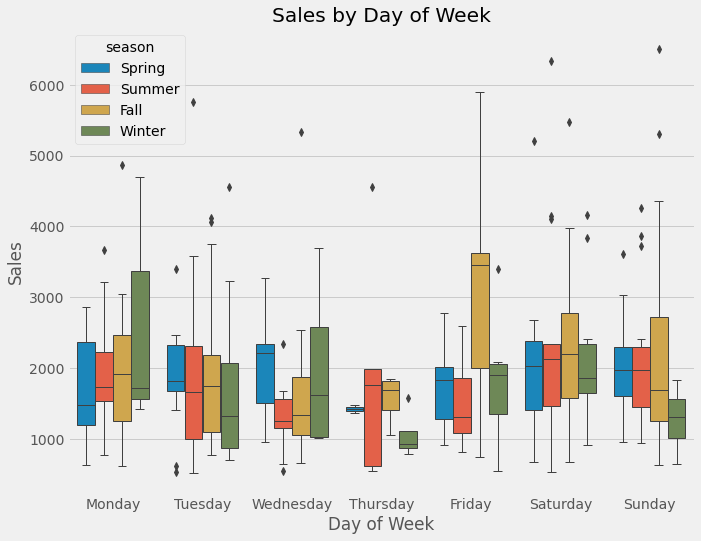

In [72]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(data=features_and_target,
            x='weekday',
            y='Sales',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Sales by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Sales')
# ax.legend(bbox_to_anchor=(1, 1))
plt.show()

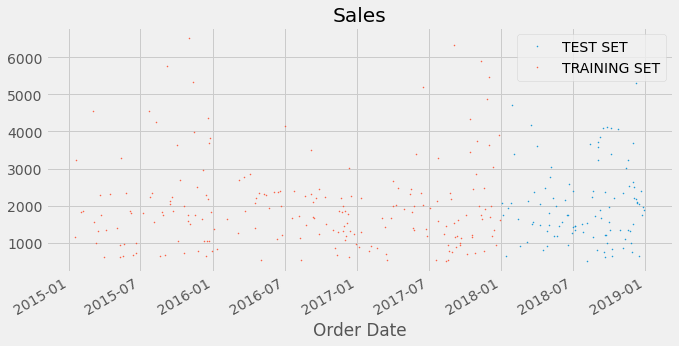

In [73]:
split_date = '1-Jan-2018'
Mutton_train = df2_grouped.loc[df2_grouped.index <= split_date].copy()
Mutton_test = df2_grouped.loc[df2_grouped.index > split_date].copy()

# Plot train and test so you can see where we have split
Mutton_test \
    .rename(columns={'Sales': 'TEST SET'}) \
    .join(Mutton_train.rename(columns={'Sales': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Sales', style='.', ms=1)
plt.show()

In [74]:
# Format data for prophet model using ds and y
Mutton_train_prophet = Mutton_train.reset_index() \
    .rename(columns={'Order Date':'ds',
                     'Sales':'y'})

In [75]:
%%time
model = Prophet()
model.fit(Mutton_train_prophet)

11:56:34 - cmdstanpy - INFO - Chain [1] start processing
11:56:34 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 78.1 ms
Wall time: 430 ms


In [76]:
Mutton_test_prophet = Mutton_test.reset_index() \
    .rename(columns={'Order Date':'ds',
                     'Sales':'y'})

Mutton_test_fcst = model.predict(Mutton_test_prophet)

In [77]:
Mutton_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,1803.433797,116.295223,2948.767713,1803.433797,1803.433797,-327.025340,-327.025340,-327.025340,-69.994759,-69.994759,-69.994759,-257.030581,-257.030581,-257.030581,0.0,0.0,0.0,1476.408457
1,2018-01-06,1802.973890,426.789628,3168.017977,1802.973890,1802.973890,-65.795436,-65.795436,-65.795436,257.691678,257.691678,257.691678,-323.487114,-323.487114,-323.487114,0.0,0.0,0.0,1737.178455
2,2018-01-14,1802.054077,440.902166,3159.918846,1802.054077,1802.054078,-13.276990,-13.276990,-13.276990,197.004581,197.004581,197.004581,-210.281571,-210.281571,-210.281571,0.0,0.0,0.0,1788.777087
3,2018-01-19,1801.479195,546.374544,3292.094770,1801.479194,1801.479195,114.788930,114.788930,114.788930,223.950022,223.950022,223.950022,-109.161092,-109.161092,-109.161092,0.0,0.0,0.0,1916.268125
4,2018-01-26,1800.674358,363.023190,3304.249610,1800.674357,1800.674359,40.655144,40.655144,40.655144,223.950022,223.950022,223.950022,-183.294878,-183.294878,-183.294878,0.0,0.0,0.0,1841.329503


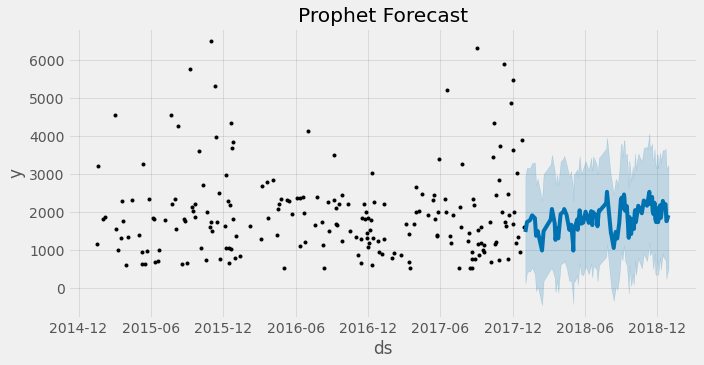

In [78]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(Mutton_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

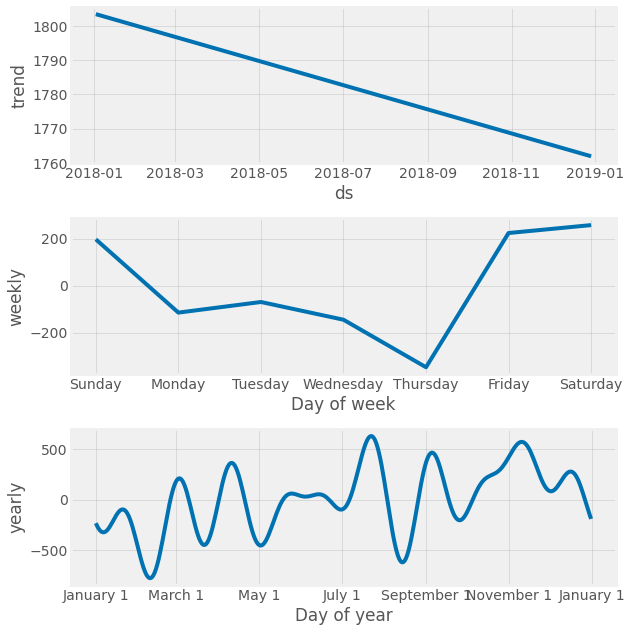

In [79]:
fig = model.plot_components(Mutton_test_fcst)
plt.show()

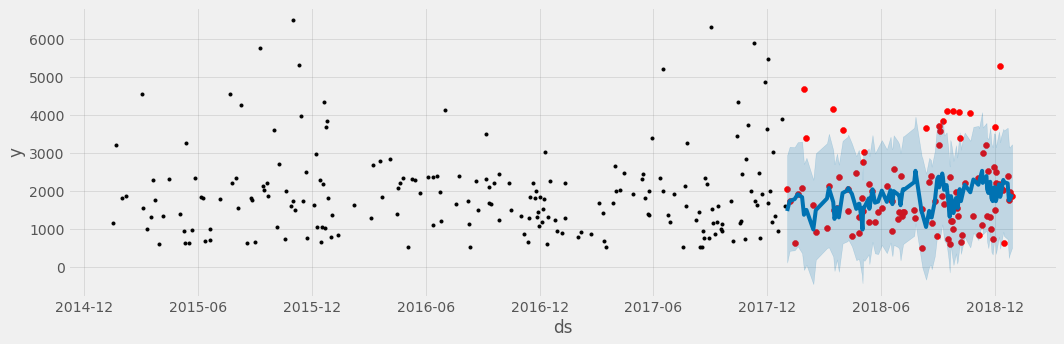

In [80]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(Mutton_test.index, Mutton_test['Sales'], color='r')
fig = model.plot(Mutton_test_fcst, ax=ax)

In [81]:
np.sqrt(mean_squared_error(y_true=Mutton_test['Sales'],
                   y_pred=Mutton_test_fcst['yhat']))

1079.583220954565

In [82]:
mean_absolute_error(y_true=Mutton_test['Sales'],
                   y_pred=Mutton_test_fcst['yhat'])

810.4964314767712

In [83]:
mean_absolute_percentage_error(y_true=Mutton_test['Sales'],
                   y_pred=Mutton_test_fcst['yhat'])

48.0919843173758

# Soft Drinks

In [84]:
df_cleaned
df2_SoftDrinks = df_cleaned.loc[df_cleaned['Sub Category'] == 'Soft Drinks']
df2 = df2_SoftDrinks[['Sales','Order Date']]
df2['Order Date'] = df2['Order Date'].str.replace('/','-')
df2_grouped = df2.groupby(['Order Date']).sum()
df2_grouped

,Sales
Order Date,
01-01-2018,3924
01-02-2016,2729
01-02-2018,503
01-03-2018,2376
01-04-2016,1449
...,...
9-28-2016,1454
9-28-2018,1461
9-29-2015,1507


In [85]:
df2_grouped.index = pd.to_datetime(df2_grouped.index,format="%m-%d-%Y", errors='coerce', dayfirst=True)

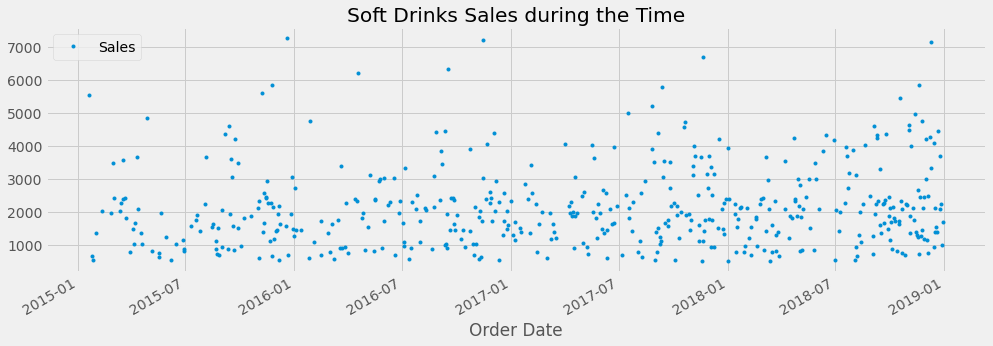

In [86]:
df2_grouped.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Soft Drinks Sales during the Time')
plt.show()

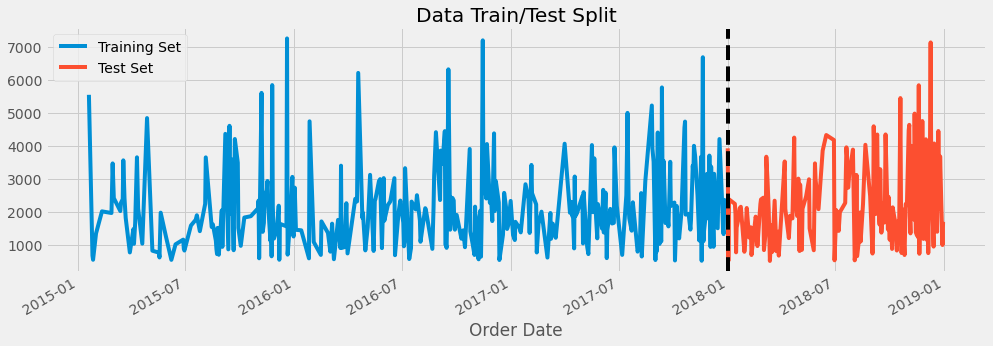

In [87]:
train = df2_grouped.loc[df2_grouped.index < '01-01-2018']
test = df2_grouped.loc[df2_grouped.index >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [88]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df2_grouped = create_features(df2_grouped)

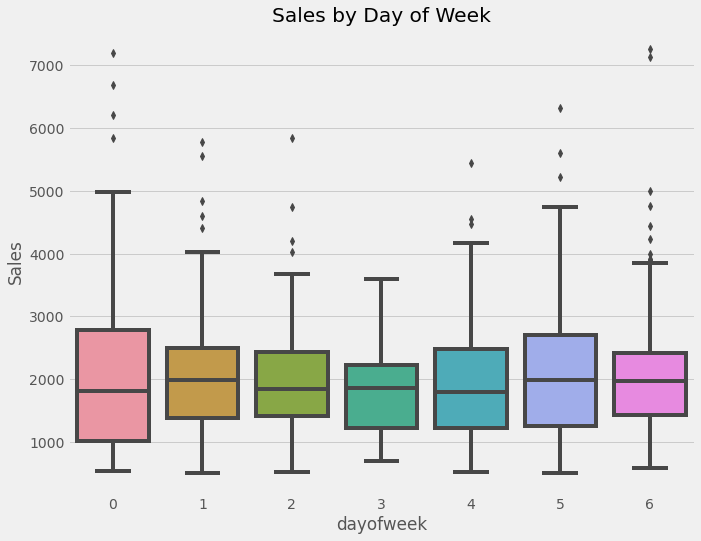

In [89]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2_grouped, x='dayofweek', y='Sales')
ax.set_title('Sales by Day of Week')
plt.show()

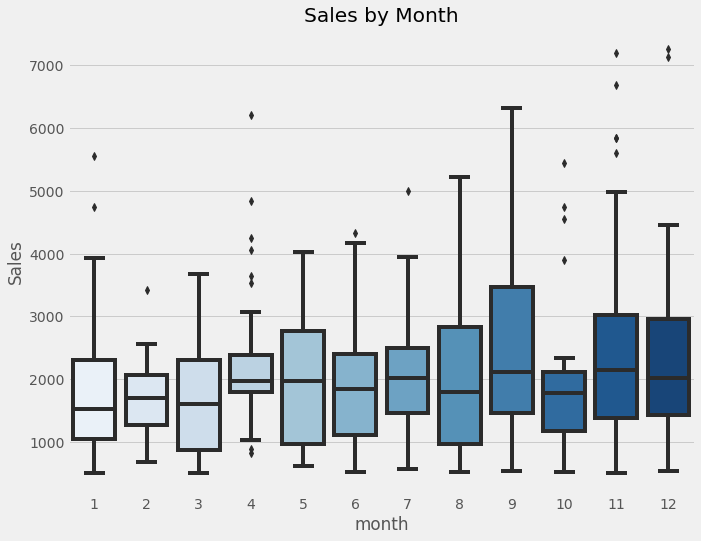

In [90]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2_grouped, x='month', y='Sales', palette='Blues')
ax.set_title('Sales by Month')
plt.show()

In [91]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Sales'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [92]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[11:56:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2406.28670	validation_1-rmse:2519.24371
[100]	validation_0-rmse:1408.99279	validation_1-rmse:1513.58952
[200]	validation_0-rmse:1165.56923	validation_1-rmse:1286.30756
[300]	validation_0-rmse:1100.34160	validation_1-rmse:1249.56525
[400]	validation_0-rmse:1062.80226	validation_1-rmse:1238.71252
[500]	validation_0-rmse:1030.68601	validation_1-rmse:1235.57541
[600]	validation_0-rmse:997.46988	validation_1-rmse:1232.47965
[628]	validation_0-rmse:990.16001	validation_1-rmse:1233.44107


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

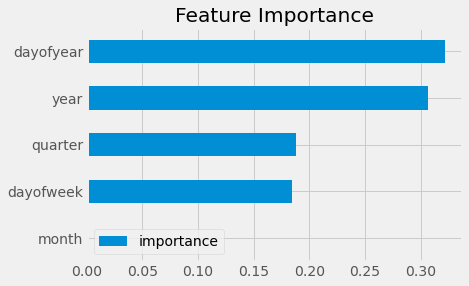

In [93]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

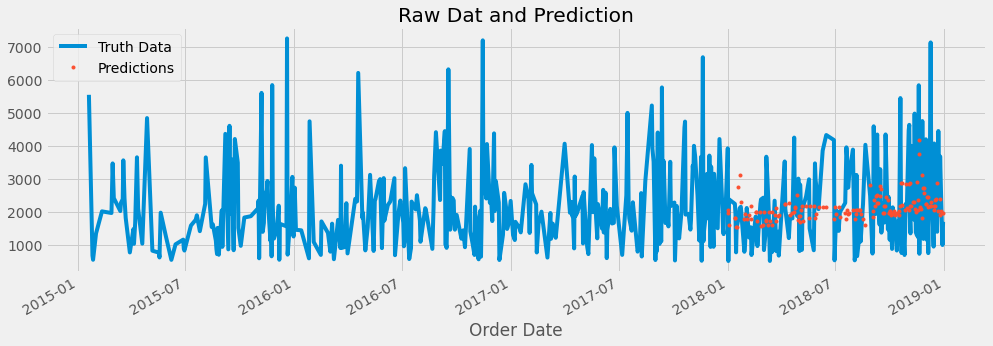

In [94]:
test['prediction'] = reg.predict(X_test)
df = df2_grouped.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df2_grouped[['Sales']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [95]:
score = np.sqrt(mean_squared_error(test['Sales'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1231.90


In [96]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2018-12-09    4975.622070
2018-10-19    3274.853516
2018-11-20    3041.684082
2018-11-12    2889.123535
2018-12-22    2444.141602
2018-08-21    2428.087769
2018-11-02    2427.291260
2018-06-29    2385.363037
2018-04-23    2272.363770
2018-09-04    2232.169434
Name: error, dtype: float64

## Prophet of Soft Drinks

In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


df = pd.read_csv("Supermart Grocery Sales - Retail Analytics Dataset.csv")

In [99]:
df_cleaned = df.drop(['Order ID','Customer Name','State'],axis=1)
df_cleaned.dtypes

Category         object
Sub Category     object
City             object
Order Date       object
Region           object
Sales             int64
Discount        float64
Profit          float64
dtype: object

In [100]:
df_cleaned
df2_SoftDrinks = df_cleaned.loc[df_cleaned['Sub Category'] == 'Soft Drinks']
df2 = df2_SoftDrinks[['Sales','Order Date']]
df2['Order Date'] = df2['Order Date'].str.replace('/','-')
df2_grouped = df2.groupby(['Order Date']).sum()
df2_grouped
df2_grouped.index = pd.to_datetime(df2_grouped.index,format="%m-%d-%Y", errors='coerce', dayfirst=True)

In [101]:
df2_grouped

,Sales
Order Date,
2018-01-01,3924
2016-01-02,2729
2018-01-02,503
2018-01-03,2376
2016-01-04,1449
...,...
2016-09-28,1454
2018-09-28,1461
2015-09-29,1507


In [102]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df2_grouped, label='Sales')
features_and_target = pd.concat([X, y], axis=1)

In [103]:
features_and_target

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,Sales
Order Date,,,,,,,,,,
2018-01-01,0,1,1,2018,1,1,1,Monday,Winter,3924
2016-01-02,5,1,1,2016,2,2,53,Saturday,Winter,2729
2018-01-02,1,1,1,2018,2,2,1,Tuesday,Winter,503
2018-01-03,2,1,1,2018,3,3,1,Wednesday,Winter,2376
2016-01-04,0,1,1,2016,4,4,1,Monday,Winter,1449
...,...,...,...,...,...,...,...,...,...,...
2016-09-28,2,3,9,2016,272,28,39,Wednesday,Fall,1454
2018-09-28,4,3,9,2018,271,28,39,Friday,Fall,1461
2015-09-29,1,3,9,2015,272,29,40,Tuesday,Fall,1507


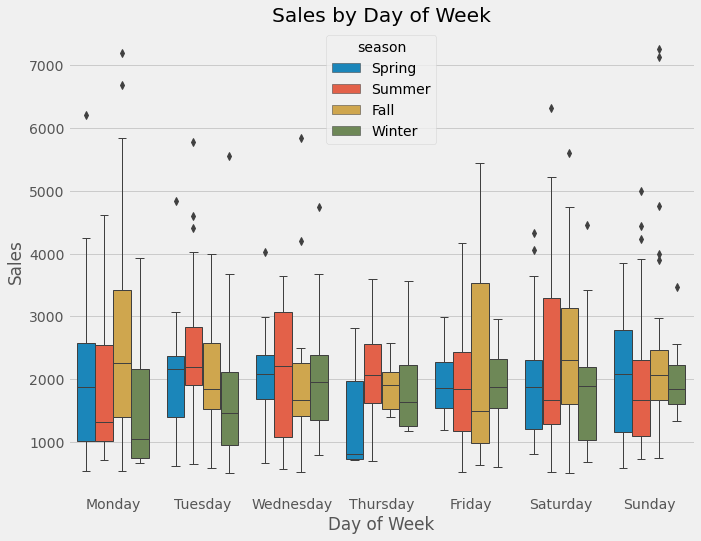

In [104]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(data=features_and_target,
            x='weekday',
            y='Sales',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Sales by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Sales')
# ax.legend(bbox_to_anchor=(1, 1))
plt.show()

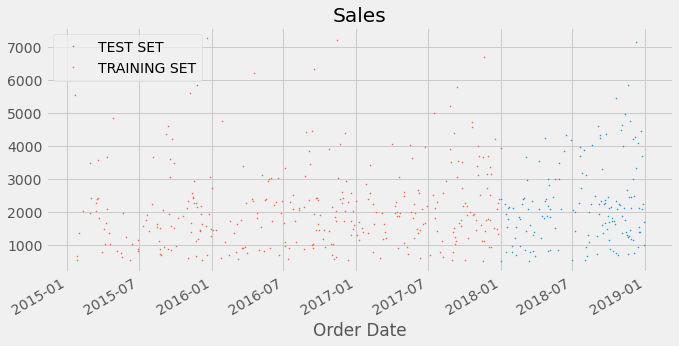

In [105]:
split_date = '1-Jan-2018'
SoftDrinks_train = df2_grouped.loc[df2_grouped.index <= split_date].copy()
SoftDrinks_test = df2_grouped.loc[df2_grouped.index > split_date].copy()

# Plot train and test so you can see where we have split
SoftDrinks_test \
    .rename(columns={'Sales': 'TEST SET'}) \
    .join(SoftDrinks_train.rename(columns={'Sales': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Sales', style='.', ms=1)
plt.show()

In [106]:
# Format data for prophet model using ds and y
SoftDrinks_train_prophet = SoftDrinks_train.reset_index() \
    .rename(columns={'Order Date':'ds',
                     'Sales':'y'})

In [107]:
%%time
model = Prophet()
model.fit(SoftDrinks_train_prophet)

11:57:07 - cmdstanpy - INFO - Chain [1] start processing
11:57:07 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 109 ms
Wall time: 459 ms


In [108]:
SoftDrinks_test_prophet = SoftDrinks_test.reset_index() \
    .rename(columns={'Order Date':'ds',
                     'Sales':'y'})

SoftDrinks_test_fcst = model.predict(SoftDrinks_test_prophet)

In [109]:
SoftDrinks_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,2108.545799,732.065718,3820.457642,2108.545799,2108.545799,94.504478,94.504478,94.504478,90.982230,90.982230,90.982230,3.522248,3.522248,3.522248,0.0,0.0,0.0,2203.050276
1,2018-01-03,2108.861663,454.006895,3591.935821,2108.861663,2108.861663,-6.802305,-6.802305,-6.802305,4.423545,4.423545,4.423545,-11.225850,-11.225850,-11.225850,0.0,0.0,0.0,2102.059358
2,2018-01-13,2112.020302,802.888909,3711.172111,2112.020302,2112.020302,95.858385,95.858385,95.858385,191.096335,191.096335,191.096335,-95.237950,-95.237950,-95.237950,0.0,0.0,0.0,2207.878686
3,2018-01-14,2112.336165,753.329171,3685.282108,2112.336165,2112.336165,119.242157,119.242157,119.242157,208.565364,208.565364,208.565364,-89.323207,-89.323207,-89.323207,0.0,0.0,0.0,2231.578323
4,2018-01-15,2112.652029,454.390235,3483.634399,2112.652029,2112.652029,-138.411887,-138.411887,-138.411887,-58.175391,-58.175391,-58.175391,-80.236496,-80.236496,-80.236496,0.0,0.0,0.0,1974.240143


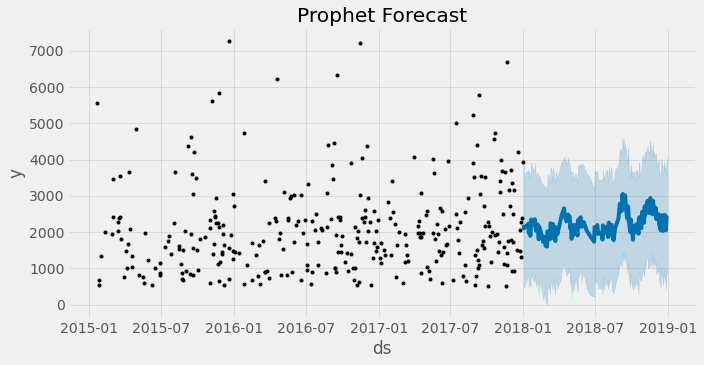

In [110]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(SoftDrinks_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

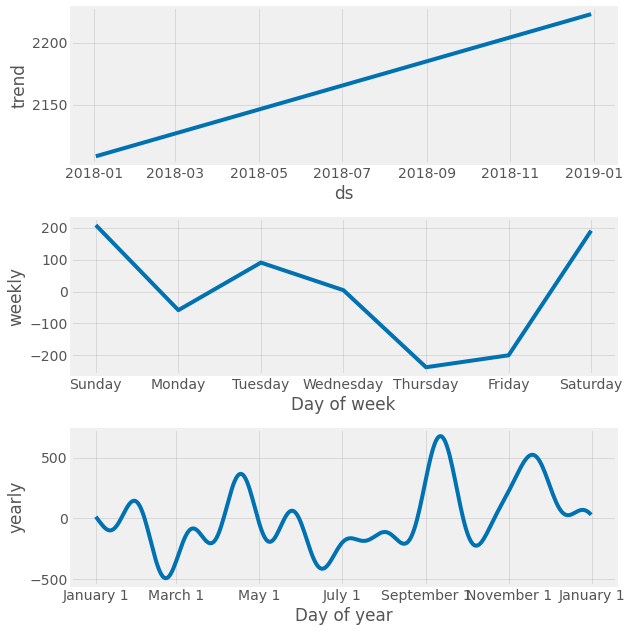

In [111]:
fig = model.plot_components(SoftDrinks_test_fcst)
plt.show()

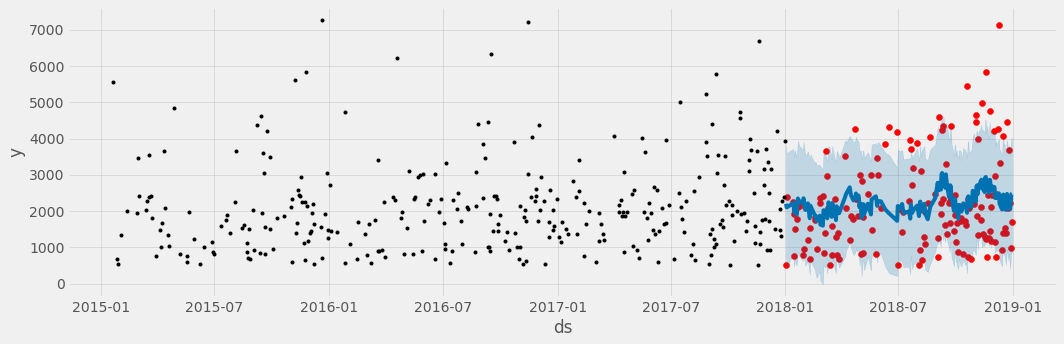

In [112]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(SoftDrinks_test.index, SoftDrinks_test['Sales'], color='r')
fig = model.plot(SoftDrinks_test_fcst, ax=ax)

In [113]:
np.sqrt(mean_squared_error(y_true=SoftDrinks_test['Sales'],
                   y_pred=SoftDrinks_test_fcst['yhat']))

1245.8305004592876

In [114]:
mean_absolute_error(y_true=SoftDrinks_test['Sales'],
                   y_pred=SoftDrinks_test_fcst['yhat'])

955.0253063792312

In [115]:
mean_absolute_percentage_error(y_true=SoftDrinks_test['Sales'],
                   y_pred=SoftDrinks_test_fcst['yhat'])

64.38658558158565